In [1]:
from openfermion.circuits import simulate_trotter
from openfermion.circuits.trotter import LOW_RANK
import openfermion
import cirq
from openfermion.transforms import get_fermion_operator
from openfermion.transforms import jordan_wigner
from openfermion.transforms import bravyi_kitaev
from openfermion import FermionOperator
from openfermion.linalg import sparse_tools

from scipy.linalg import eigh
import scipy
import re 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

In [2]:
def generate_spins(N):
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    return si_n, sx_list, sy_list, sz_list

def qubit_hamiltonian_to_qutip(q_hamiltonian, N):
    # first we generate the spin operators in qutip
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    
    # read the qubit_hamiltonian from openfermion
    l_h = list(q_hamiltonian)
    s_h_0 = str(l_h[0])
    t1_0 = s_h_0.split()
    numero_0 = t1_0[0].split('+')[0].split('(')[1]
    numero_0 = float(numero_0)
    H = numero_0*si_n
    
    for i in range(1,len(l_h)): 
        s_h = str(l_h[i])
        t1 = s_h.split()
        numero = t1[0].split('+')[0].split('(')[1]
        numero = float(numero)
        lletres = [t1[1][1]]
        numeros = [int(t1[1][2])]
        lletres2 = [j[0] for j in t1[2:]]
        numeros2 = [int(j[1]) for j in t1[2:]]
        let = lletres+lletres2
        num = numeros+numeros2
        H_i = numero*si_n
        for k in range(0,len(let)):
            if let[k] == 'X':
                H_i = H_i*sx_list[num[k]]
            if let[k] == 'Y':
                H_i = H_i*sy_list[num[k]]
            if let[k] == 'Z':
                H_i = H_i*sz_list[num[k]]
            else : 
                H_i = H_i
        H = H + H_i
    
    return H


def generate_Hb(N):
    # N is the length of the chain
    
    si = qeye(2)
    sx = sigmax()
    
    sx_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

    # construct the hamiltonian
    Hb = 0

    for n in range(N):
        Hb += 1/2*(si_n- sx_list[n])
        
    return Hb

def Hp_coeff(t, args):
    tau = args['tau']# time scale of the adiabatic evolution
    exp = args['exp']# in case we want a nonlinear interpolation
    return (t/tau)**exp

def Hb_coeff(t,args):
    tau = args['tau'] # time scale of the adiabatic evolution
    exp = args['exp']# in case we want a nonlinear interpolation
    return 1-(t/tau)**exp


def adiabatic_evolution(H, N, args, psi0, tlist, plot = True):
    # H: Hamiltonian in the format H = [[Hb, Hb_coeff],[Hp, Hp_coeff]]
    # args: arguments of the time dependent function of the hamiltonian, args = {'tau': tau}
    # psi0: initial state to be evolved
    # tlist: list of times for which the evolution is calculated
    
    c_op_list = [] # we are not using any colapse operators
    si = qeye(2)
    sz = sigmaz()
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
    options = Options(nsteps=100000, store_states = True)
        
    result = mesolve(H, psi0, tlist, c_op_list, sz_list, args = args, options = options) # calculate the expected value of the sigma_z
    #result_state = mesolve(H, psi0, tlist, c_op_list, args = args, options = options) # calculate evolved state at each time
    
    # plot sigma_z evolution
    if plot == True:
        plt.subplots(figsize=(10,6))
        plt.imshow(np.real(result.expect), interpolation = 'nearest', extent=[tlist[0], tlist[-1], N, 0], aspect = 'auto')
        plt.aspect_ratio = 1
        plt.colorbar()
        plt.xlabel(r'Time')
        plt.yticks(list(range(N)))
        plt.ylabel(r'N site')
        plt.title(r'$\langle\sigma_z\rangle$ evolution')
        
    return result.expect, result.states

def entanglement_entropy(state, partition):
    # Returns the Von Neumann entropy of the partial trace
    # state - state for which we want to calculate the entanglement entropy
    # partition - integer or array of integers from 0 to N-1 that indicate the subsystem
    # with respect to which we calculate the partial trace
    dm = state*state.dag()
    partial_dm = dm.ptrace(partition)
    return entropy_vn(partial_dm, base = 2)

def overlap_with_ground(H, states, tlist, n, plot = True):
    # n = number of lowest states with which the overlap will be calculated
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=n, tol=0, maxiter=100000)
    overlaps = []
    for i in range(n):
        overlap = []
        for state in states:
            overlap.append(abs(eigenstates[1][i].overlap(state))**2)
        overlaps.append(overlap)
    if plot == True:
        plt.figure(figsize=(8,6))
        for i in range(n):
            plt.plot(tlist, overlaps[i], label = '%.0f th state'%i)
        plt.xlabel('time')
        plt.ylabel('overlap square')
        plt.legend()
    return overlaps

def H_time(t, Hb, Hp, tau, exp):
    # Time dependent hamiltonian as a function
    return (1-(t/tau)**exp)* Hb + ((t/tau )**exp) * Hp

def diff_Hs(t, Hb, Hp, tau, exp):
    # Derivative with respect to adiabatic parameter s of the time dependent hamiltonian
    return (-exp*(t/tau)**(exp-1))* Hb + exp*((t/tau )**(exp-1)) * Hp
     
def gap_evolution(H, tlist, plot = True):
    # Hamiltonian evaluated at different times
    energy_0 = [] # ground state energies
    energy_1 = [] # first excited state energies
    gap = [] # diference between ground and first excited energies
    
    for H_i in H:
        energies = H_i.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
        energy_0.append(energies[0])
        energy_1.append(energies[1])
        gap.append(energies[1]-energies[0])

    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(tlist, gap)
        plt.xlabel(r'Time')
        plt.ylabel(r'Gap')
    return energy_0, energy_1

def dHs(dH, Hs, tlist, plot = True):
    state_0_s = []
    state_1_s = []
    braket = []
    
    for i in range(0,len(Hs)):
        eigenstates = Hs[i].eigenstates(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
        state_0_s.append(eigenstates[1][0])
        state_1_s.append(eigenstates[1][1])
        braket.append(np.abs(dH[i].matrix_element(state_1_s[-1], state_0_s[-1])))
    
    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(tlist, braket)
        plt.xlabel(r'$t/\tau$')
        plt.ylabel(r'$|\langle 1,s|dH/ds| 0,s\rangle|$')
    return state_0_s, state_1_s, braket

def entanglement_ground(H, tlist, partition):
    entanglement = []
    for i in range(0, len(tlist)):
        H_i = H[i]
        eigenstates = H_i.eigenstates(sparse=False, sort='low', eigvals=1, tol=0, maxiter=100000)
        entanglement.append(entanglement_entropy(eigenstates[1][0], partition))
    return entanglement

In [21]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
N = 4
H_dist_JW = []
H_dist_BK = []
HF_e = []
FCI_e = []
entanglement = []
gap = []
distances = np.linspace(0.2,3,25)
r0 = 0.74

for dist in distances:
    geometry = [['H',[0,0,0]],
           ['H',[0,0,dist]]]
    basis = 'sto-3g'
    multiplicity = 1
    charge = 0
    h2_molecule = MolecularData(geometry, basis, multiplicity, charge)

    #If it is the first time executing this program uncomment the following lines
    h2_molecule = run_pyscf(h2_molecule,
                       run_mp2 = True,
                       run_cisd = True,
                       run_ccsd = True,
                       run_fci = True)
    h2_filename = h2_molecule.filename
    h2_molecule.save()

    h2_molecule.load()
    HF_e.append(h2_molecule.hf_energy)
    FCI_e.append(h2_molecule.fci_energy)
    h2_hamiltonian = h2_molecule.get_molecular_hamiltonian()
    fermion_hamiltonian = get_fermion_operator(h2_hamiltonian)
    qubit_hamiltonian_JW = jordan_wigner(fermion_hamiltonian)
    H_dist_JW.append(qubit_hamiltonian_to_qutip(qubit_hamiltonian_JW, N))
    qubit_hamiltonian_BK = bravyi_kitaev(fermion_hamiltonian)
    H_dist_BK.append(qubit_hamiltonian_to_qutip(qubit_hamiltonian_BK, N))

In [35]:
gap = []
entanglement_JW = []
entanglement_BK = []
partition = [0,1]
energy_0 = []
energy_1 = []
for H in H_dist_JW:
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=1, tol=0, maxiter=100000)
    entanglement_JW.append(entanglement_entropy(eigenstates[1][0], partition))
    energies = H.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
    energy_0.append(energies[0])
    energy_1.append(energies[1])
    gap.append(energies[1]-energies[0])
for H in H_dist_BK:
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=1, tol=0, maxiter=100000)
    entanglement_BK.append(entanglement_entropy(eigenstates[1][0], partition))

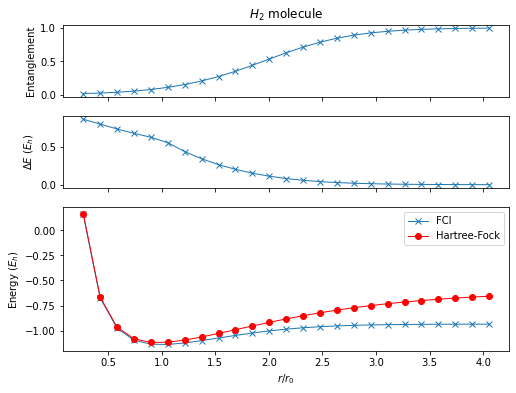

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})
ax1.plot(distances/r0, entanglement_JW, 'x-', label = 'Exact', linewidth = 1)
#ax1.plot(distances/r0, entanglement_BK, 'o-', label = 'Exact', linewidth = 1)
ax2.plot(distances/r0, gap, 'x-', linewidth = 1)
ax3.plot(distances/r0, FCI_e, 'x-', label = 'FCI',  linewidth = 1)
ax3.plot(distances/r0, HF_e, 'o-', label = 'Hartree-Fock', color = 'red',linewidth = 1)


ax3.set_xlabel(r'$r/r_0$')
ax3.set_ylabel('Energy $(E_h)$')
ax2.set_ylabel('$\Delta E$ $(E_h)$')
ax1.set_ylabel('Entanglement')
ax3.legend()
ax1.set_title('$H_2$ molecule')
plt.savefig('H2energy.png', bbox_inches='tight')

In [28]:
N = 4
Hb = generate_Hb(N)
ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb
adiabatic_times = []
i = 1
tau = 10
for Hp in H_dist:
    ground_final = Hp.groundstate(sparse=False, tol=0, maxiter=100000)
    psifinal = ground_final[1]
#Hp = qubit_hamiltonian_to_qutip(qubit_hamiltonian, N)  
    exp = 1
    while tau<=15000:
        args = {'tau': tau, 'exp': exp}
        tlist = np.linspace(0, tau, tau*2)
        evolved_states = []
        # time dependent hamiltonian
        H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]
        expect, evolved_state = adiabatic_evolution(H, N, args, psi0, tlist, plot = False)
        overlap = abs(psifinal.overlap(evolved_state[-1]))**2
        if overlap>=0.99:
            adiabatic_times.append(tau)           
            break
        else:
            if i<= 12:
                tau += 10
            if 17>=i> 12:
                tau += 100
            if i>17:
                tau += 1000
    i += 1
    tau = adiabatic_times[-1]

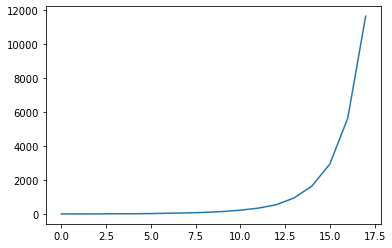

In [29]:
plt.plot(range(len(adiabatic_times)), adiabatic_times)

In [30]:
len(adiabatic_times)

18

In [20]:
len(distances)

21

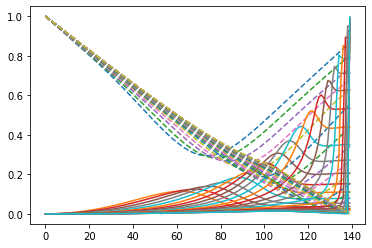

In [32]:
tau = 70 # time scale of the adiabatic evolution
exp = 1
tlist = np.linspace(0, tau, tau*2)
partition = [2]
s_entanglement = [] # adiabatic evolution parameter for which the entanglement of |l=0,s> is maximum
s_gap = [] # adiabatic evolution parameter for which the gap happens
for Hp in H_dist_BK:
    N = 4
    Hb = generate_Hb(N)
    H_t = []
    for t in tlist:
        H_t.append(H_time(t, Hb, Hp, tau, exp))
    energy0, energy1 = gap_evolution(H_t, tlist, plot = False)
    gap = np.subtract(energy1, energy0)
    entanglement = entanglement_ground(H_t, tlist, partition)
    plt.plot(gap, '--')
    plt.plot(entanglement)
    s_entanglement.append(tlist[np.argmax(entanglement)]/tau)
    s_gap.append(tlist[np.argmin(gap)]/tau)

Text(0, 0.5, 's_entanglement')

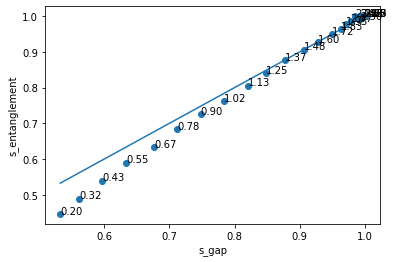

In [34]:
plt.scatter(s_gap,s_entanglement)
plt.plot(s_gap, s_gap)
for i, txt in enumerate(distances):
    plt.annotate(format(txt, '.2f'), (s_gap[i], s_entanglement[i]))
plt.xlabel('s_gap')
plt.ylabel('s_entanglement')